In [3]:
#not included by default
!pip install rasterio 

     |████████████████████████████████| 19.1MB 1.2MB/s 


In [2]:
#imports 

from PIL import Image 
import rasterio 
import pandas as pd
import numpy as np
from matplotlib import image as im
from matplotlib import pyplot as plt
from affine import Affine
from keras import layers
from keras import Input
import keras

In [5]:
filepath ='MapBiomas/C5-2019.tif'
#path to the MapBiomas land cover file from collection 5 in 2019 - here renamed C5-2019.tif

with rasterio.open(filepath) as src:
    print(src.profile)
    #some some basic info

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 113487, 'height': 81381, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -73.98327050645874,
       0.0, -0.00026949458523585647, 5.269697119701937), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


For interpretation of these keys visit: https://rasterio.readthedocs.io/en/latest/quickstart.html

In [6]:
#another way of retrieving similar info
src.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 113487,
 'height': 81381,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00026949458523585647, 0.0, -73.98327050645874,
        0.0, -0.00026949458523585647, 5.269697119701937)}

In [7]:
print(src.bounds) #how much are edges of the image away from the reference coordinate point
print(src.crs) #coordinate system
src.indexes

BoundingBox(left=-73.98327050645874, bottom=-16.662041721377296, right=-43.39913851179709, top=5.269697119701937)
EPSG:4326


(1,)

Text(0, 0.5, 'Row #')

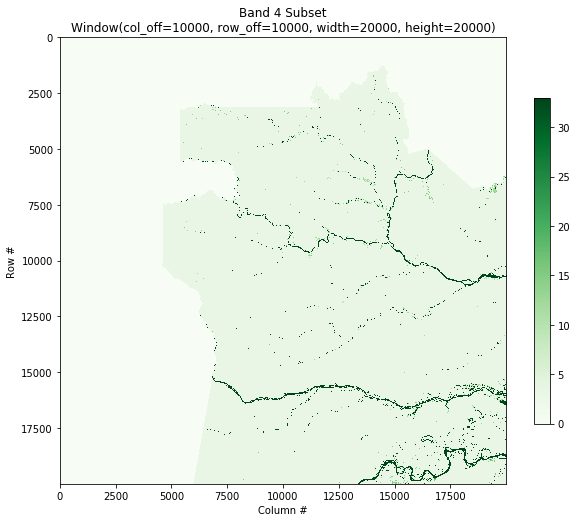

In [8]:
#visualize part of the image

window = rasterio.windows.Window(10000, 10000, 20000, 20000)

with rasterio.open(filepath) as src:
    subset = src.read(1, window=window)

plt.figure(figsize=(10,12))
plt.imshow(subset,  cmap='Greens')
plt.colorbar(shrink=0.5)
plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

# Data generator

On label groups see "MAPBIOMAS_Col5_Legenda_Cores.xlsx"

In [9]:
#label gruops 
labels = {"forest" : [1,2,3,4,5,9], "non-forest natural" : [10,11,12,32,29,13], "farming" : [14,15,18,19,39,20,41,36,21], "non-vegetated" : [22,23,24,30,25,26,33,31,27]}

def map_labels(row):
    for pixel in range(len(row)):
        if row[pixel] in labels["forest"]:
            row[pixel] = 1
        elif row[pixel] in labels["non-forest natural"]:
            row[pixel] = 2
        elif row[pixel] in labels["farming"]:
            row[pixel] = 3
        elif row[pixel] in labels["non-vegetated"]:
            row[pixel] = 4

In [17]:
#this function could be used to generate the window from which we crop the file 
#not used 
def window_from_extent(xmin, xmax, ymin, ymax, aff):
    col_start, row_start = ~aff * (xmin, ymax)
    col_stop, row_stop = ~aff * (xmax, ymin)
    return ((int(row_start), int(row_stop)), (int(col_start), int(col_stop)))

In [11]:
def data_gen(filepath):
    src = rasterio.open(filepath)
    for i in range(158):
        for j in range(221):
            window = rasterio.windows.Window(int(i*512),int(j*512), int((i*512)+512), int((j*512)+512))
            yield(src.read(1, window=window).reshape((512, 512, 1)))

In [12]:
def label_gen(filepath):
    src = rasterio.open(filepath)
    for i in range(158):
        for j in range(221):
            window = rasterio.windows.Window(int(i*512),int(j*512), int((i*512)+512), int((j*512)+512))
            yield(np.array(list(map(map_labels, src.read(1, window=window).reshape((512, 512, 1))))))

In [13]:
def build_model(input_layer, start_neurons):
    conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    pool1 = layers.Dropout(0.25)(pool1)

    conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    pool2 = layers.Dropout(0.5)(pool2)

    conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    pool3 = layers.Dropout(0.5)(pool3)

    conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)
    pool4 = layers.Dropout(0.5)(pool4)

    convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = layers.concatenate([deconv4, conv4])
    uconv4 = layers.Dropout(0.5)(uconv4)
    uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = layers.concatenate([deconv3, conv3])
    uconv3 = layers.Dropout(0.5)(uconv3)
    uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = layers.concatenate([deconv2, conv2])
    uconv2 = layers.Dropout(0.5)(uconv2)
    uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = layers.concatenate([deconv1, conv1])
    uconv1 = layers.Dropout(0.5)(uconv1)
    uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input(shape=(512,512,1))
output_layer = build_model(input_layer, 64)

In [14]:
model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(
   learning_rate = 0.001))

In [16]:
model.fit_generator(data_gen(filepath), label_gen(filepath), epochs=10)

Instructions for updating:
Please use Model.fit, which supports generators.


TypeError: '>' not supported between instances of 'int' and 'generator'